# Time Analysis

### Explanation
In this notebook will be analysed the temporal différence between the moment a command is sent by the state machine and the moment it is received by the Tool object.

First, let's import the necessary libraries and load the data.

## Libraries

In [21]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


Now let's load the two log files and parse them to extract the necessary information.

## Data

In [22]:
with open("../../../StateMachine/log.txt", "r") as f:
    log_sm_raw = f.read()

with open("../../log.txt", "r") as f:
    log_tool_raw = f.read()

log_sm_raw_lines   = log_sm_raw.split("\n")
log_tool_raw_lines = log_tool_raw.split("\n")

print("StateMachine log lines:", len(log_sm_raw_lines))
print("Tool log lines        :", len(log_tool_raw_lines))

# print an example of each log
print("StateMachine log example ================")
print(log_sm_raw_lines[len(log_sm_raw_lines) - 2])

StateMachine log lines: 30
Tool log lines        : 261
StateMachine log example ================
[INFO] - 2024-05-22 10:04:16,624 - Transition    S4 - S4          -->    S5 - S5


In [23]:
# [INFO] - 2024-05-21 12:07:56,908 - Transition    S0 - S0          -->    S1 - S1

class LogLine:
    def __init__(self, type:str, date_time:datetime, message:str):
        self.type = type
        self.date_time = date_time
        self.message = message
    
    @classmethod
    def from_line(cls, line):
        if not line:
            return None
        parts = line.split(" - ")
        if len(parts) < 3:
            return None
        type = parts[0][1:-1]
        date_time_str = parts[1]
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S,%f')
        message = " - ".join(parts[2:])
        return cls(type, date_time, message)
    
    def __str__(self):
        return f"[{self.type}] - {self.date_time} - {self.message}"
    
    def __repr__(self):
        return f"LogLine({self.type}, {self.date_time}, {self.message})"

In [24]:
# Parse log lines
log_sm_lines = [LogLine.from_line(line) for line in log_sm_raw_lines]
log_tool_lines = [LogLine.from_line(line) for line in log_tool_raw_lines]

print("StateMachine log example ================")
print(log_sm_lines[len(log_sm_lines) - 2])
print(log_sm_lines[len(log_sm_lines) - 2].__dict__)

StateMachine log example ================
[INFO] - 2024-05-22 10:04:16.624000 - Transition    S4 - S4          -->    S5 - S5
{'type': 'INFO', 'date_time': datetime.datetime(2024, 5, 22, 10, 4, 16, 624000), 'message': 'Transition    S4 - S4          -->    S5 - S5'}


In [25]:
log_sm_df = pd.DataFrame([line.__dict__ for line in log_sm_lines if line is not None])
log_tool_df = pd.DataFrame([line.__dict__ for line in log_tool_lines if line is not None])

log_tool_df.head()

,type,date_time,message
0,INFO,2024-05-22 10:02:16.298,Starting the T9_LEDS process...
1,INFO,2024-05-22 10:02:16.917,T9_LEDS object initialized successfully.
2,INFO,2024-05-22 10:02:16.917,Executing command: stop (Tools/T9_LEDS/fast_co...
3,INFO,2024-05-22 10:02:17.026,Starting the T0_ReadAudio process...
4,INFO,2024-05-22 10:02:17.901,T0_ReadAudio object initialized successfully.


In [26]:
# add column detail to log_tool_df with
# - "stop" if "Executing command: stop" in message
# - "start" if "Executing command: start" in message
# add column concerned_tool with the state concerned by the command

def parse_tool_message(message):
    possible_tools = {"T0_ReadAudio", "T1_PersonRecognition", "T2_TextGeneration", "T3_TTS", "T4_ActionSelection", "T5_PerformAction", "T6_RecordAudio", "T7_CaptureImages", "T8_STT", "T9_LEDS", "T10_RetrieveAndAugment"}
    for tool in possible_tools:
        if tool in message:
            return tool
    return None

log_tool_df["detail"] = np.where(log_tool_df["message"].str.contains("Executing command: stop"), "stop", 
                                 np.where(log_tool_df["message"].str.contains("Executing command: start"), "start",
                                          np.where(log_tool_df["message"].str.contains("Finished."), "end",
                                          None)))
log_tool_df["concerned_tool"] = log_tool_df["message"].apply(lambda x: parse_tool_message(x))

# add column detail to log_sm_df with
# - "transition" if "Transition" in message
# add column transition_from and transition_to with the from and to states

def parse_transition_message(message):
    if not 'Transition' in message:
        return None, None
    parts = message.split()
    return parts[3], parts[7]

log_sm_df["detail"] = np.where(log_sm_df["message"].str.contains("Transition"), "transition", None)
log_sm_df["transition_from"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[0] if x is not None else None)
log_sm_df["transition_to"] = log_sm_df["message"].apply(lambda x: parse_transition_message(x)[1] if x is not None else None)

log_sm_df.head()

,type,date_time,message,detail,transition_from,transition_to
0,INFO,2024-05-22 10:03:17.119,StateMachine initialized,None,None,None
1,INFO,2024-05-22 10:03:17.129,Starting StateMachine with initial state S0 - S0,None,None,None
2,INFO,2024-05-22 10:03:19.238,Transition S0 - S0 --> S1 - S1,transition,S0,S1
3,INFO,2024-05-22 10:03:21.444,Transition S1 - S1 --> S2 - S2,transition,S1,S2
4,INFO,2024-05-22 10:03:23.651,Transition S2 - S2 --> S3 - S3,transition,S2,S3


In [27]:
log_sm_tempdf = log_sm_df.copy()
log_tool_tempdf = log_tool_df.copy()

# new level column with 1 for info and 2 for error
log_sm_tempdf["level"] = log_sm_tempdf["type"].apply(lambda x: -1 if x == "INFO" else -2)
log_tool_tempdf["level"] = log_tool_tempdf["type"].apply(lambda x: 1 if x == "INFO" else 2)
log_combined = pd.concat([log_sm_tempdf, log_tool_tempdf])

log_combined = log_combined.sort_values(by="date_time")

log_combined.head()

,type,date_time,message,detail,transition_from,transition_to,level,concerned_tool
0,INFO,2024-05-22 10:02:16.298,Starting the T9_LEDS process...,None,NaN,NaN,1,T9_LEDS
2,INFO,2024-05-22 10:02:16.917,Executing command: stop (Tools/T9_LEDS/fast_co...,stop,NaN,NaN,1,T9_LEDS
1,INFO,2024-05-22 10:02:16.917,T9_LEDS object initialized successfully.,None,NaN,NaN,1,T9_LEDS
3,INFO,2024-05-22 10:02:17.026,Starting the T0_ReadAudio process...,None,NaN,NaN,1,T0_ReadAudio
4,INFO,2024-05-22 10:02:17.901,T0_ReadAudio object initialized successfully.,None,NaN,NaN,1,T0_ReadAudio


In [28]:
log_only_detailed = log_combined[log_combined["detail"].notnull()]

# get all unique pairs of detail and level
unique_pairs = log_only_detailed.groupby(["detail", "level"]).size().reset_index().rename(columns={0: "count"})
dict_detail_number = dict()
neg_count, pos_count = -1, 1
for detail, level in unique_pairs[["detail", "level"]].values:
    # if level is negative, assign negative number, else assign positive number
    if level < 0:
        dict_detail_number[detail] = neg_count
        neg_count -= 1
    else:
        dict_detail_number[detail] = pos_count
        pos_count += 1

log_only_detailed["level"] = log_only_detailed["detail"].apply(lambda x: dict_detail_number[x])

log_only_detailed.head()

C:\Users\echriston\AppData\Local\Temp\ipykernel_10344\3065180358.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_only_detailed["level"] = log_only_detailed["detail"].apply(lambda x: dict_detail_number[x])


,type,date_time,message,detail,transition_from,transition_to,level,concerned_tool
2,INFO,2024-05-22 10:02:16.917,Executing command: stop (Tools/T9_LEDS/fast_co...,stop,NaN,NaN,3,T9_LEDS
9,INFO,2024-05-22 10:02:18.778,Executing command: stop (Tools/T6_RecordAudio/...,stop,NaN,NaN,3,T6_RecordAudio
24,INFO,2024-05-22 10:02:30.677,Executing command: stop (Tools/T7_CaptureImage...,stop,NaN,NaN,3,T7_CaptureImages
2,INFO,2024-05-22 10:03:19.238,Transition S0 - S0 --> S1 - S1,transition,S0,S1,-1,NaN
30,INFO,2024-05-22 10:03:19.240,Executing command: start (Tools/T0_ReadAudio/f...,start,NaN,NaN,2,T0_ReadAudio


## First Analysis

Let's start by plotting all the commands sent by the state machine and the moment they were received by the Tool object.

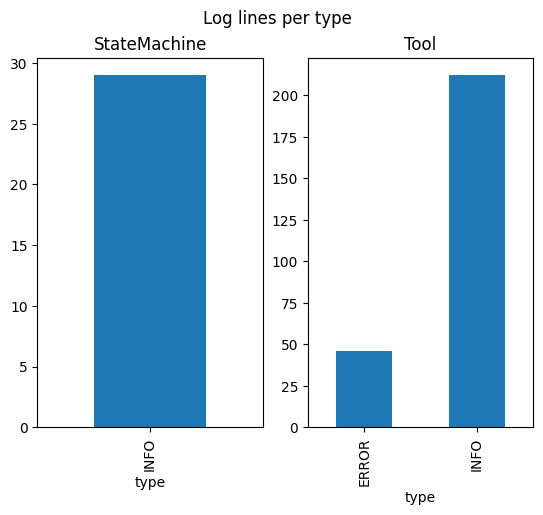

In [29]:
# plot the number of log lines per type
fig = plt.figure()
plt.subplot(1, 2, 1)
log_sm_df.groupby("type").size().plot(kind='bar', title="StateMachine")

plt.subplot(1, 2, 2)
log_tool_df.groupby("type").size().plot(kind='bar', title="Tool")
# sup title
plt.suptitle("Log lines per type")
plt.show()


In [41]:

def plot_timeline(df, column_label, raw_label=None):
    fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)

    for i, (key, grp) in enumerate(df.groupby(["level"])):
        markerline, stemline, baseline = ax.stem(grp["date_time"], grp["level"], linefmt=f"C{i}-", basefmt="k-", label=key)

        plt.setp(markerline, mec="k", mfc="w", zorder=3)
        markerline.set_ydata(np.zeros(len(grp["date_time"])))

        # text
        plt.text(grp["date_time"].iloc[0], grp["level"].iloc[0] + (0.1 * np.sign(grp["level"].iloc[0])), grp[column_label].iloc[0], color=f"C{i}", rotation=0, verticalalignment="center", fontsize=10)

        if raw_label:
            for index, row in grp.iterrows():
                if np.sign(row["level"]) == 1:
                    alignement = "bottom"
                    y = 0.1 + row["level"]
                else:
                    alignement = "top"
                    y = -0.1 + row["level"]
                plt.text(row["date_time"], y, row[raw_label], color=f"C{i}", rotation=90, verticalalignment=alignement, horizontalalignment="left", fontsize=6)

    # second offset = 1/20 of the range
    sec_offset = max(round((df["date_time"].max() - df["date_time"].min()).total_seconds() / 20), 1)
    print(sec_offset)
    init_date = df["date_time"].min()
    init_date = init_date.replace(second=init_date.second - sec_offset)
    plt.text(init_date, -0.6, "StateMachine", color="black", rotation=0, verticalalignment="center")
    plt.text(init_date, 0.6, "Tool", color="black", rotation=0, verticalalignment="center")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)

    plt.show()


6


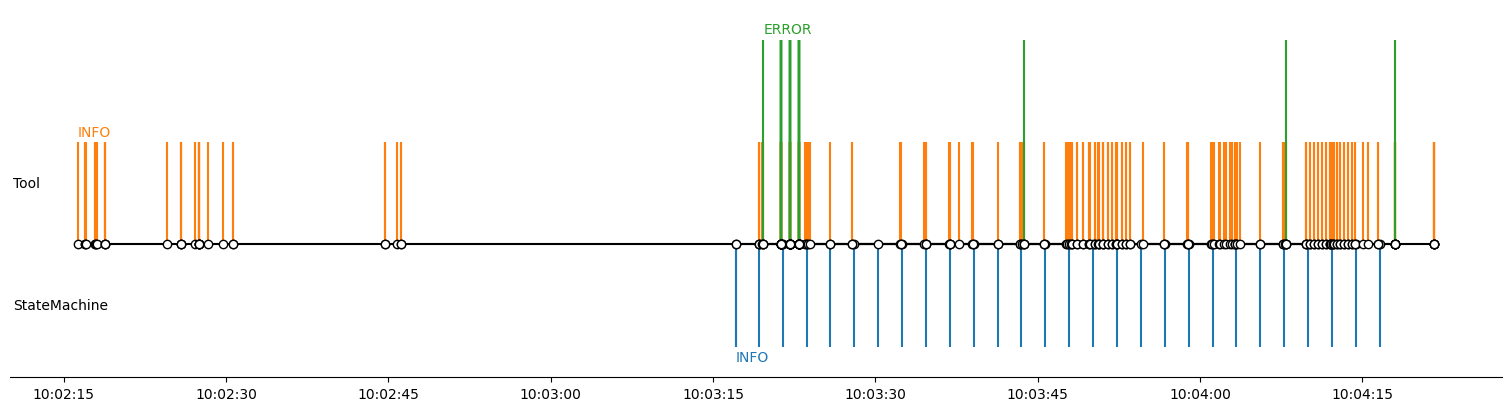

6


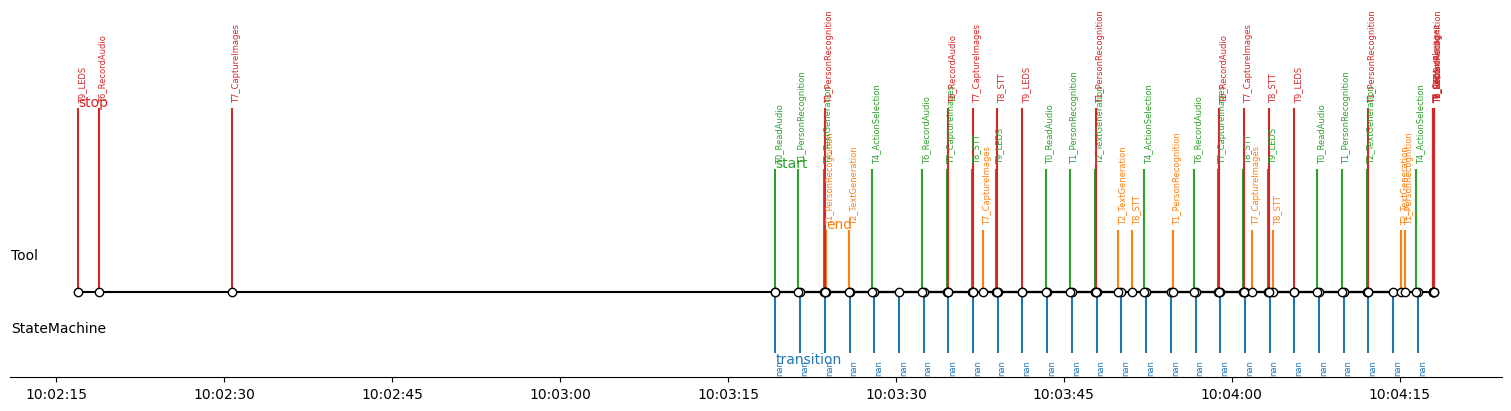

In [42]:
plot_timeline(log_combined, "type")
plot_timeline(log_only_detailed, "detail", "concerned_tool")

1


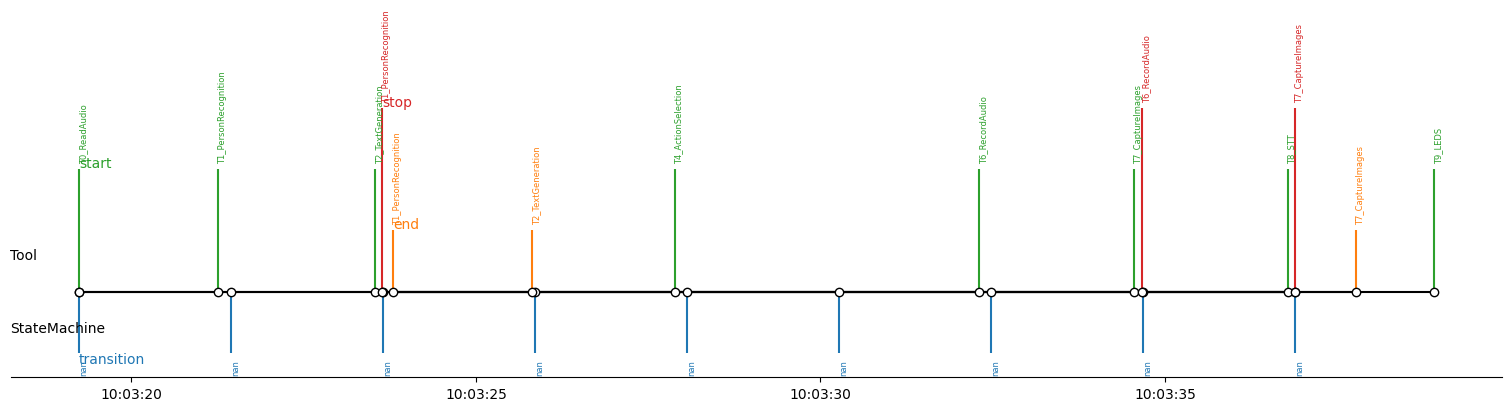

In [44]:
log_zoomed_only_detailed = log_only_detailed[(log_only_detailed["date_time"] > datetime(2024, 5, 22, 10, 3, 19, 0)) & (log_only_detailed["date_time"] < datetime(2024, 5, 22, 10, 3, 39, 0))]
plot_timeline(log_zoomed_only_detailed, "detail", "concerned_tool")